In [319]:
using Revise
using PastaQ
using ITensors
using Random
using OptimKit
using Zygote
using Zygote: ChainRulesCore
using BenchmarkTools
using LinearAlgebra
using JLD2
using Flux
using PyCall
using SymPy
using QOS

import mVQE
using mVQE.Hamiltonians: hamiltonian_tfi, hamiltonian_ghz
using mVQE.ITensorsExtension: projective_measurement
using mVQE: loss, optimize_and_evolve
using mVQE.Circuits: VariationalCircuitRy, VariationalMeasurement, VariationalMeasurementMC, VariationalMeasurementMCFeedback
using mVQE.Misc: get_ancillas_indices, pprint
using mVQE.Optimizers: OptimizerWrapper
using mVQE.pyflexmps: pfs

## Translation from spin One to Spin Half

In [97]:
spin_trans = Dict()
for i in [0, 2]
    spin_trans[pfs.KetSpinOne("1", i)] = pfs.KetSpinHalf.from_spin1(stot=1, sz=1, n1=i, n2=i+1)
    spin_trans[pfs.KetSpinOne("0", i)] = pfs.KetSpinHalf.from_spin1(stot=1, sz=0, n1=i, n2=i+1)
    spin_trans[pfs.KetSpinOne("-1", i)] = pfs.KetSpinHalf.from_spin1(stot=1, sz=-1, n1=i, n2=i+1)
end
spin_trans

Dict{Any, Any} with 6 entries:
  |1_0>  => |1/2_0>*|1/2_1>
  |0_0>  => sqrt(2)*|-1/2_0>*|1/2_1>/2 + sqrt(2)*|1/2_0>*|-1/2_1>/2
  |-1_0> => |-1/2_0>*|-1/2_1>
  |-1_2> => |-1/2_2>*|-1/2_3>
  |1_2>  => |1/2_2>*|1/2_3>
  |0_2>  => sqrt(2)*|-1/2_2>*|1/2_3>/2 + sqrt(2)*|1/2_2>*|-1/2_3>/2

In [98]:
pfs.KetSpinHalf.quantum_states

Dict{Any, Any} with 2 entries:
  "1/2"  => 0
  "-1/2" => 1

In [99]:
spin_trans_girvin = Dict()
for i in [0, 2]
    spin_trans_girvin[pfs.KetSpinOne("1", i)] = pfs.KetSpinHalf("-1/2", i)*pfs.KetSpinHalf("1/2", i+1)
    spin_trans_girvin[pfs.KetSpinOne("0", i)] = pfs.KetSpinHalf("1/2", i)*pfs.KetSpinHalf("1/2", i+1)
    spin_trans_girvin[pfs.KetSpinOne("-1", i)] = pfs.KetSpinHalf("1/2", i)*pfs.KetSpinHalf("-1/2", i+1)
end
spin_trans_girvin

Dict{Any, Any} with 6 entries:
  |1_0>  => |-1/2_0>*|1/2_1>
  |0_0>  => |1/2_0>*|1/2_1>
  |-1_0> => |1/2_0>*|-1/2_1>
  |-1_2> => |1/2_2>*|-1/2_3>
  |1_2>  => |-1/2_2>*|1/2_3>
  |0_2>  => |1/2_2>*|1/2_3>

## Hamiltonian

In [100]:
S = [[pfs.sigmax(j), pfs.sigmay(j), pfs.sigmaz(j)] for j in 0:3]
hilberts = [S[i][1].hilbert_space.__pyobject__ for i in 1:4]

4-element Vector{PyObject}:
 PyObject H_0
 PyObject H_1
 PyObject H_2
 PyObject H_3

In [101]:
"""


S0 = S[1] .+ S[2]
S1 = S[3] .+ S[4]
SS = sum(S0 .* S1)
ham_aklt = SS/2 + (SS ^ 2)/6 + 1/3 * pfs.sigma("id", 0)
ham_aklt = pfs.apply(expand(ham_aklt), hilberts_order=hilberts)
""";

In [102]:
ham_aklt = 0
for i in -2:2
    state = pfs.KetSpinOne.from_spin2(stot=2, sz=i, n1=0, n2=2)
    state = subs(state, spin_trans)
    ham_aklt += pfs.projector(state)
end
ham_aklt

sigma(+,0,False)⋅sigma(+,1,False)⋅sigma(-,2,False)⋅sigma(-,3,False)   sigma(+,
─────────────────────────────────────────────────────────────────── + ────────
                                 6                                            

0,False)⋅sigma(-,1,False)⋅sigma(+,2,False)⋅sigma(-,3,False)   sigma(+,0,False)
─────────────────────────────────────────────────────────── + ────────────────
                         6                                                    

⋅sigma(-,1,False)⋅sigma(-,2,False)⋅sigma(+,3,False)   sigma(+,0,False)⋅sigma(-
─────────────────────────────────────────────────── + ────────────────────────
                 6                                                            

,1,False)⋅sigma(P+,2,False)⋅sigma(P+,3,False)   sigma(+,0,False)⋅sigma(-,1,Fal
───────────────────────────────────────────── + ──────────────────────────────
          4                                                                   

se)⋅sigma(P+,2,False)⋅sigma(P-,3,False)   sigma(

In [103]:
singlet = pfs.KetSpinHalf.from_spin1(stot=0, sz=0, n1=0, n2=1)
ham_spin1 = pfs.projector(singlet)

  sigma(+,0,False)⋅sigma(-,1,False)   sigma(-,0,False)⋅sigma(+,1,False)   sigm
- ───────────────────────────────── - ───────────────────────────────── + ────
                  2                                   2                       

a(P+,0,False)⋅sigma(P-,1,False)   sigma(P-,0,False)⋅sigma(P+,1,False)
─────────────────────────────── + ───────────────────────────────────
             2                                     2                 

In [104]:
ham_aklt_girvin = 0
for i in -2:2
    state = pfs.KetSpinOne.from_spin2(stot=2, sz=i, n1=0, n2=2)
    state = subs(state, spin_trans_girvin)
    ham_aklt_girvin += pfs.projector(state)
end
ham_aklt_girvin

sigma(+,0,False)⋅sigma(-,1,False)⋅sigma(-,2,False)⋅sigma(+,3,False)   sigma(+,
─────────────────────────────────────────────────────────────────── + ────────
                                 6                                            

0,False)⋅sigma(P+,1,False)⋅sigma(-,2,False)⋅sigma(P+,3,False)   sigma(+,0,Fals
───────────────────────────────────────────────────────────── + ──────────────
                          2                                                   

e)⋅sigma(P+,1,False)⋅sigma(P+,2,False)⋅sigma(+,3,False)   sigma(-,0,False)⋅sig
─────────────────────────────────────────────────────── + ────────────────────
                    3                                                         

ma(+,1,False)⋅sigma(+,2,False)⋅sigma(-,3,False)   sigma(-,0,False)⋅sigma(P+,1,
─────────────────────────────────────────────── + ────────────────────────────
             6                                                                

False)⋅sigma(+,2,False)⋅sigma(P+,3,False)   sigm

In [105]:
singlet = pfs.KetSpinHalf("-1/2", 0) * pfs.KetSpinHalf("-1/2", 1)
ham_spin1_girvin = pfs.projector(singlet)

sigma(P-,0,False)⋅sigma(P-,1,False)

In [106]:
function H_aklt_tot(hilbert_state)
    N_state = length(hilbert_state)
    op1 = mVQE.pyflexmps.convert_sympy_to_opsum(ham_aklt, Vector(1:2:N_state-2))
    op2 = mVQE.pyflexmps.convert_sympy_to_opsum(ham_spin1, Vector(1:2:N_state))
    return MPO(op1 + op2, hilbert_state), MPO(op1, hilbert_state), MPO(op2, hilbert_state)
end

function H_aklt_tot_girvin(hilbert_state)
    N_state = length(hilbert_state)
    op1 = mVQE.pyflexmps.convert_sympy_to_opsum(ham_aklt_girvin, Vector(1:2:N_state-2))
    op2 = mVQE.pyflexmps.convert_sympy_to_opsum(ham_spin1_girvin, Vector(1:2:N_state))
    return MPO(op1 + op2, hilbert_state), MPO(op1, hilbert_state), MPO(op2, hilbert_state)
end

H_aklt_tot_girvin (generic function with 1 method)

## Gates
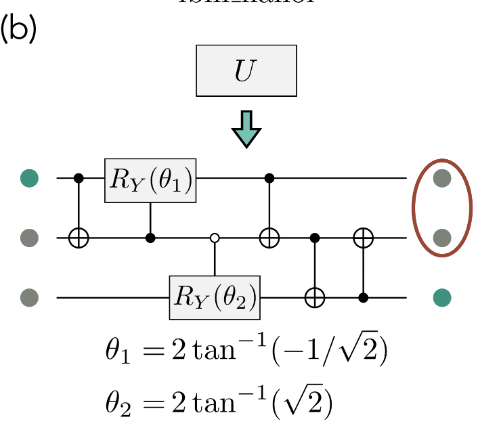

In [601]:
singlet_gate(i1, i2)=[("X", i1), ("X", i2), ("H", i2), ("CX", (i2, i1))]


θ_1 = 2 * atan(-1 / sqrt(2))
θ_2 = 2 * atan(sqrt(2))

U_gate_L(c_in, i1, i2) =[("CX", (c_in, i1)), ("CRy", (i1, c_in), (θ = θ_1,)), ("X", i1),("CRy", (i1, i2), (θ = θ_2,)), ("X", i1),
                        ("CX", (c_in, i1)), ("CX", (i1, i2)), ("CX", (i2, i1))]

U_gate_R(c_in, i1, i2) =[("CX", (c_in, i1)), ("CRy", (i1, c_in), (θ = θ_1,)), ("X", i1),("CRy", (i1, i2), (θ = θ_2,)), ("X", i1),
                        ("CX", (c_in, i1)), ("CX", (i1, i2)), ("CX", (i2, i1)), ("SWAP", c_in, i1)]


U_gate2(c_in, i1, i2) = [("CX", (c_in, i1)), ("CRy", (i1, c_in), (θ = θ_1,)), ("CRy", (i1, i2), (θ = θ_2,)),
                        ("CX", (c_in, i1)), ("CX", (i1, i2)), ("CX", (i2, i1))]

U_gate_L_(i0, i1, i2) = U_gate_L(i2, i1, i0)
#U_gate_R(i3, i4, i5) = U_gate_R(i3, i4, i5)

U2_gate(i0, i1, i2, i3, i4, i5) = vcat(U_gate_L_(i0, i1, i2), U_gate_R(i3, i4, i5))
    
bell_gate(i0, i1) = [("CX", (i1, i0)), ("H", i1)]

bell_gate (generic function with 1 method)

### Understanding U

In [372]:
pfs.Spin1("+", 0)

Spin1(+,0,False)

In [373]:
Utot = (pfs.sigma("+", 0) * pfs.Spin1("+", 1) - pfs.sigma("-", 0) * pfs.Spin1("-", 1)  - pfs.sigma("z", 0)*pfs.Spin1("id", 1)) / sympy.sqrt(2)
Utot += (pfs.sigma("+", 2) * pfs.Spin1("+", 3) - pfs.sigma("-", 2) * pfs.Spin1("-", 3)  - pfs.sigma("z", 2)*pfs.Spin1("id", 3)) / sympy.sqrt(2)
ψ_0 = (pfs.KetSpinHalf("-1/2", 0) * pfs.KetSpinOne("0", 1) * pfs.KetSpinHalf("1/2", 2) * pfs.KetSpinOne("0", 3) - pfs.KetSpinHalf("1/2", 0) * pfs.KetSpinOne("0", 1) * pfs.KetSpinHalf("-1/2", 2) * pfs.KetSpinOne("0", 3))/sympy.sqrt(2)

√2⋅(❘-1/20⟩⋅❘01⟩⋅❘1/22⟩⋅❘03⟩ - ❘1/20⟩⋅❘01⟩⋅❘-1/22⟩⋅❘03⟩)
────────────────────────────────────────────────────────
                           2                            

In [374]:
pfs.apply(Utot * ψ_0)

√2⋅❘-1/20⟩⋅❘-11⟩⋅❘-1/22⟩⋅❘03⟩   √2⋅❘-1/20⟩⋅❘01⟩⋅❘-1/22⟩⋅❘-13⟩   √2⋅❘1/20⟩⋅❘01⟩
───────────────────────────── - ───────────────────────────── - ──────────────
              2                               2                             2 

⋅❘1/22⟩⋅❘13⟩   √2⋅❘1/20⟩⋅❘11⟩⋅❘1/22⟩⋅❘03⟩
──────────── + ──────────────────────────
                           2             

In [375]:
pfs.KetSpinOne.from_spin2(stot=0, sz=0, n1=1, n2=3)

√3⋅❘-11⟩⋅❘13⟩   √3⋅❘01⟩⋅❘03⟩   √3⋅❘11⟩⋅❘-13⟩
───────────── - ──────────── + ─────────────
      3              3               3      

In [376]:
ss = pfs.BraSpinOne("-1", 1) * pfs.BraSpinOne("0", 3)
s = 0
for i in -1:1:1
    s += pfs.apply(ss * pfs.KetSpinOne.from_spin2(stot=1, sz=i, n1=1, n2=3)) ^2
end
s += pfs.apply(ss * pfs.KetSpinOne.from_spin2(stot=0, sz=0, n1=1, n2=3)) ^2
1-s

1/2

#### Construct U from A

In [377]:
using Einsum
A = zeros((2, 3, 2))
A[1, 1, 2] = sqrt(2/3) 

A[1, 2, 1] = -sqrt(1/3) 
A[2, 2, 2] = sqrt(1/3) 

A[2, 3, 1] = -sqrt(2/3);

P = zeros((2, 3, 2))
P[1, 1, 1] = 1

P[1, 2, 2] = sqrt(1/2) 
P[2, 2, 1] = sqrt(1/2) 

P[2, 3, 2] = 1;


P_girvin = zeros((2, 3, 2))
P_girvin[2, 1, 1] = 1
P_girvin[1, 2, 1] = 1
P_girvin[1, 3, 2] = 1;

In [378]:
∑ = zeros(2, 2)
∑[1, 2] = 1 / sqrt(2)
∑[2, 1] = -1 / sqrt(2)
∑

2×2 Matrix{Float64}:
  0.0       0.707107
 -0.707107  0.0

In [379]:
@einsum A_2[i, j, k] := P[i, j, α] * ∑[α, k];
print_non_zero(A_2)

[ 1, 1, 2] : 0.70711
[ 1, 2, 1] : -0.50000
[ 2, 2, 2] : 0.50000
[ 2, 3, 1] : -0.70711


In [380]:
s = zeros(3)
s[2] = 1

1

In [522]:
@einsum U[s1_i, h_i, s1_j, h_j] := A[h_i, s1_i, h_j] * s[s1_j];
print_non_zero(U)

[1, 1, 2, 2] =>  0.81650
[2, 1, 2, 1] => -0.57735
[2, 2, 2, 2] =>  0.57735
[3, 2, 2, 1] => -0.81650


In [524]:
# Convert spin1 - 2Xspinhalf
@einsum U_half_crafted[hc_i, h1_i, h2_i, hc_j, h1_j, h2_j] := U[s1_i, hc_i, s1_j, hc_j] * P_girvin[h1_i, s1_i, h2_i] * P_girvin[h1_j, s1_j, h2_j]
print_non_zero(U_half_crafted)

[1, 1, 1, 1, 1, 1] => -0.57735
[1, 2, 1, 2, 1, 1] =>  0.81650
[2, 1, 1, 2, 1, 1] =>  0.57735
[2, 1, 2, 1, 1, 1] => -0.81650


In [525]:
@einsum U_half_crafted_swap[h1_i, h2_i, hc_i, hc_j, h1_j, h2_j] := U[s1_i, hc_i, s1_j, hc_j] * P_girvin[h1_i, s1_i, h2_i] * P_girvin[h1_j, s1_j, h2_j];

In [526]:
@einsum U_half_crafted_swap_right[h2_i, h1_i, hc_i, hc_j, h1_j, h2_j] := U[s1_i, hc_i, s1_j, hc_j] * P_girvin[h1_i, s1_i, h2_i] * P_girvin[h1_j, s1_j, h2_j];

#### Construct U directly as an operator

In [383]:
Splus = pfs.sigma("P+", 1) * pfs.sigma("+", 2) + pfs.sigma("-", 1) * pfs.sigma("P+", 2)
Sminus = Splus.adjoint()
up_state = pfs.KetSpinHalf("-1/2", 1) * pfs.KetSpinHalf("1/2", 2)
zero_state = pfs.KetSpinHalf("1/2", 1) * pfs.KetSpinHalf("1/2", 2)
down_state = pfs.KetSpinHalf("1/2", 1) * pfs.KetSpinHalf("-1/2", 2)

❘1/21⟩⋅❘-1/22⟩

In [384]:
pfs.apply(Splus * zero_state)- up_state, pfs.apply(Splus * down_state)- zero_state, pfs.apply(Sminus * down_state), pfs.apply(Sminus * up_state - zero_state), pfs.apply(Sminus * zero_state - down_state) 

(0, 0, 0, 0, 0)

In [528]:
U_sym = (pfs.sigma("+", 0) * Splus - pfs.sigma("-", 0) * Sminus - pfs.sigma("z", 0)) / sqrt(2)
U_sym = pfs.insert_identity(U_sym, hilberts[1:3])
#U_sym = pfs.KetSpinHalf("-1/2", 0)*pfs.KetSpinHalf("1/2", 1)*pfs.KetSpinHalf("1/2", 2)
#U_sym = pfs.projector(U_sym)
#U_sym = pfs.quantum_operators.mirror(U_sym)

0.707106781186547⋅sigma(+,0,False)⋅sigma(-,1,False)⋅sigma(P+,2,False) + 0.7071
06781186547⋅sigma(+,0,False)⋅sigma(P+,1,False)⋅sigma(+,2,False) - 0.7071067811
86547⋅sigma(-,0,False)⋅sigma(+,1,False)⋅sigma(P+,2,False) - 0.707106781186547⋅
sigma(-,0,False)⋅sigma(P+,1,False)⋅sigma(-,2,False) - 0.707106781186547⋅sigma(
z,0,False)⋅sigma(id,1,False)⋅sigma(id,2,False)

In [529]:
pfs.apply(U_sym * pfs.KetSpinHalf("1/2", 0) * zero_state)

-0.707106781186547⋅❘-1/20⟩⋅❘1/21⟩⋅❘-1/22⟩ - 0.707106781186547⋅❘1/20⟩⋅❘1/21⟩⋅❘1
/22⟩

In [560]:
Um_ = pfs.matrix_form_subspace(U_sym, [0, 1, 2], reshape=false)
Um = permutedims(Um_, (3, 2, 1, 6, 5, 4))
ITensors.op(::OpName"U_aklt", ::SiteType"Qubit") = Array(reshape(Um, 8, 8))
        
U_aklt_sw = permutedims(U_half_crafted_swap, (3, 2, 1, 6, 5, 4))
ITensors.op(::OpName"U_aklt_sw", ::SiteType"Qubit") = Array(reshape(U_aklt_sw, 8, 8))
        
U_aklt_sw_right = permutedims(U_half_crafted_swap_right, (3, 2, 1, 6, 5, 4))
ITensors.op(::OpName"U_aklt_sw_R", ::SiteType"Qubit") = Array(reshape(U_aklt_sw_right, 8, 8))
    
U2_gate_2(i0, i1, i2, i3, i4, i5) = [("U_aklt_sw", (i2, i1, i0)), ("U_aklt_sw_R", (i3, i4, i5))]

U2_gate_2 (generic function with 1 method)

In [534]:
hilbert_ = qubits(3);

000

In [535]:
gate = ("U_aklt_sw", (1, 2, 3))
ψ_1 = runcircuit(ψ, gate)
t = contract(ψ_1[1:end]).tensor
print_non_zero(t)

[1, 1, 1, 1, 1, 1] => -0.57735
[1, 2, 2, 1, 1, 1] => -0.81650


In [536]:
gate = U_gate2(1, 2, 3)
ψ = productstate(hilbert_, [0, 0, 0]);
ψ_2 = runcircuit(ψ, gate)
t = contract(ψ_2[1:end]).tensor
print_non_zero(t)

[1, 1, 1] =>  0.57735
[1, 2, 2] =>  0.81650


In [537]:
print_non_zero(U_half_crafted_swap[:, :, :, 1, 1, 1])

[1, 1, 1] => -0.57735
[1, 2, 2] => -0.81650


100

In [538]:
gate = ("U_aklt_sw", (1, 2, 3))
ψ2 = productstate(hilbert_, [1, 0, 0]);
ψ_1 = runcircuit(ψ2, gate)
t = contract(ψ_1[1:end]).tensor
print_non_zero(t)

[1, 1, 2] =>  0.57735
[2, 1, 1] =>  0.81650


In [439]:
gate = U_gate2(1, 2, 3)
ψ = productstate(hilbert_, [1, 0, 0]);
ψ_2 = runcircuit(ψ, gate)
t = contract(ψ_2[1:end]).tensor
print_non_zero(t)

[ 1, 1, 2] : 0.57735
[ 2, 1, 1] : 0.81650


In [440]:
print_non_zero(U_half_crafted_swap[:, :, :, 2, 1, 1])

[ 1, 1, 2] : 0.57735
[ 2, 1, 1] : 0.81650


## Rotate into girvin frame of reference

In [441]:
girvin_rot = zeros(2, 2, 2, 2)
girvin_rot[2, 1, 1, 1] = 1

girvin_rot[1, 1, 1, 2] = 1/sqrt(2)
girvin_rot[1, 1, 2, 1] = 1/sqrt(2)

girvin_rot[1, 2, 2, 2] = 1


girvin_rot[2, 2, 1, 2] = 1/sqrt(2)
girvin_rot[2, 2, 2, 1] = -1/sqrt(2)


girvin_rot = reshape(girvin_rot, (4,4))

ITensors.op(::OpName"girvin_rot", ::SiteType"Qubit") =  Array(transpose(girvin_rot))
ITensors.op(::OpName"girvin_rot_T", ::SiteType"Qubit") = girvin_rot

In [442]:
girvin_kill = zeros(2, 2, 2, 2)
girvin_kill[2, 2, 2, 2] = 1

girvin_kill = reshape(girvin_kill, (4,4))

ITensors.op(::OpName"girvin_kill", ::SiteType"Qubit") =  Array(transpose(girvin_kill))

### Aklt half state construction

In [156]:
using Einsum

In [157]:
∑ = zeros(2, 2)
∑[1, 2] = 1 / sqrt(2)
∑[2, 1] = -1 / sqrt(2)
∑

2×2 Matrix{Float64}:
  0.0       0.707107
 -0.707107  0.0

In [158]:
M = zeros(2, 2, 3)
M[1, 1, 1] = 1

M[1, 2, 2] = 1 / sqrt(2)
M[2, 1, 2] = 1 / sqrt(2)

M[2, 2, 3] = 1
M;

## 4 body AKLT

In [443]:
function norm_(ψ)
    n = norm(ψ)
    return ψ/n
end

norm_ (generic function with 1 method)

In [444]:
N_state = 4
state_indices, ancilla_indices, N = get_ancillas_indices(N_state, [false, true, true, true, true, false])
hilbert = qubits(N)

hilbert_state = hilbert[state_indices]
hilbert_ancilla = hilbert[ancilla_indices]

ψ = productstate(hilbert, fill(0, N))
state_indices, ancilla_indices, N

([2, 3, 4, 5], [1, 6], 6)

In [445]:
H, H_aklt, H_spin1 = H_aklt_tot_girvin(hilbert_state);

### Theory

In [446]:
aklts = mVQE.StateFactory.AKLT_halfs(hilbert[state_indices], basis="girvin");

In [447]:
aklts2 = mVQE.StateFactory.AKLT_halfs(hilbert[state_indices]);

In [448]:
gates_girvin_rot = [("girvin_rot", i, i+1) for i in 1:2:N_state]
one_aklt_rot = runcircuit(aklts[4], gates_girvin_rot)
[inner(aklt, one_aklt_rot)^2 for aklt in aklts2]

4-element Vector{Float64}:
 1.0000000000000004
 4.1505799198966917e-35
 4.108650548026101e-34
 0.03999999999999998

In [449]:
gates_girvin_rot = [("girvin_kill", i, i+1) for i in 1:2:N_state]
one_aklt_rot = runcircuit(aklts[4], gates_girvin_rot)

MPS
[1] ((dim=2|id=929|"Qubit,Site,n=2"), (dim=1|id=110|"Link,n=1"))
[2] ((dim=1|id=110|"Link,n=1"), (dim=2|id=652|"Qubit,Site,n=3"), (dim=2|id=188|"Link,n=2"))
[3] ((dim=2|id=858|"Qubit,Site,n=4"), (dim=2|id=188|"Link,n=2"), (dim=1|id=920|"Link,n=1"))
[4] ((dim=1|id=920|"Link,n=1"), (dim=2|id=102|"Qubit,Site,n=5"))


In [450]:
inner(aklts[4], one_aklt_rot)

0.0

In [451]:
[inner(aklt, H_aklt, aklt) for aklt in aklts]

4-element Vector{Float64}:
 -1.4456736846207887e-16
 -1.0289892457876184e-16
 -1.8343182262917545e-16
 -6.633914702911159e-17

In [452]:
[inner(aklt, H_spin1, aklt) for aklt in aklts]

4-element Vector{Float64}:
 -1.4341817372594356e-17
  2.4836958235360675e-33
  8.67911612700002e-34
  0.0

In [453]:
[[inner(aklt, aklt2)^2 for aklt in aklts] for aklt2 in aklts]

4-element Vector{Vector{Float64}}:
 [0.9999999999999996, 2.465190328815661e-34, 1.8454582378989077e-33, 0.03999999999999992]
 [2.465190328815661e-34, 1.0, 0.0, 0.0]
 [1.8454582378989077e-33, 0.0, 1.0000000000000004, 6.162975822039153e-35]
 [0.03999999999999992, 0.0, 6.162975822039153e-35, 1.0]

### DMRG

In [454]:
maxdim_ = 10
nsweeps = 100
start_mps = randomMPS(hilbert_state, linkdims=maxdim_)
Edmrg, Φ = dmrg(H, start_mps; outputlevel=0, nsweeps, maxdim=maxdim_)
println("Ground state energy from DMRG: $Edmrg")
Φ

Ground state energy from DMRG: 1.1818418745782947e-17


MPS
[1] ((dim=2|id=636|"Link,l=1"), (dim=2|id=929|"Qubit,Site,n=2"))
[2] ((dim=3|id=635|"Link,l=2"), (dim=2|id=652|"Qubit,Site,n=3"), (dim=2|id=636|"Link,l=1"))
[3] ((dim=2|id=858|"Qubit,Site,n=4"), (dim=2|id=256|"Link,l=3"), (dim=3|id=635|"Link,l=2"))
[4] ((dim=2|id=102|"Qubit,Site,n=5"), (dim=2|id=256|"Link,l=3"))


In [455]:
inner(Φ, H_spin1, Φ)

-1.035323499589805e-17

In [456]:
inner(Φ, H_aklt, Φ)

-8.059034901249607e-17

In [457]:
[inner(aklt, Φ)^2 for aklt in aklts]

4-element Vector{Float64}:
 0.06013290579795169
 0.010798907688186626
 0.38361435250201287
 0.5970201319099254

In [458]:
sum([inner(aklt, Φ)^2 for aklt in aklts])

1.0515662978980767

### With gates

In [604]:
gates = vcat(singlet_gate(3, 4), U2_gate(1, 2, 3, 4, 5, 6))
ψ = productstate(hilbert, fill(0, N))
ψ2 = runcircuit(ψ, gates)
ψ3 = mVQE.ITensorsExtension.reduce_MPS(ψ2, [1,6], [2, 2])

println(norm(ψ3)^2)
ψ3 = norm_(ψ3)

println(inner(ψ3, H_aklt, ψ3)," ", inner(ψ3, H_spin1, ψ3))

0.2222222222222225
8.713852901040922e-18 1.7166979703698093e-17


In [592]:
gates = vcat(singlet_gate(3, 4), U2_gate_2(1, 2, 3, 4, 5, 6))
ψ2 = runcircuit(ψ, gates)
println(norm(ψ2))
ψ3 = mVQE.ITensorsExtension.reduce_MPS(ψ2, [1, 6], [2, 2])

println(norm(ψ3)^2)
ψ3 = norm_(ψ3)

println(inner(ψ3, H_aklt, ψ3)," ", inner(ψ3, H_spin1, ψ3))

0.9999999999999999
0.22222222222222232
-5.1499021275194155e-17 2.21262257243707e-17


In [593]:
print_non_zero(contract(ψ3[1:end]).tensor)

[1, 1, 2, 1] => -0.70711
[2, 1, 1, 1] =>  0.70711


In [594]:
print_non_zero(contract(aklts[1][:]).tensor)

[1, 1, 1, 1] =>  0.44721
[2, 1, 1, 2] => -0.89443


In [595]:
sum([inner(aklt, ψ3)^2 for aklt in aklts])

0.9999999999999998

In [596]:
[inner(aklt, ψ3)^2 for aklt in aklts]

4-element Vector{Float64}:
 4.0834767383804695e-32
 0.9999999999999998
 4.9935350946256196e-64
 2.328934133412633e-33

## 8 body AKLT

In [605]:
N_state = 8
state_indices, ancilla_indices, N = get_ancillas_indices(N_state, [false, true, true, true, true, false])
hilbert = qubits(N)

hilbert_state = hilbert[state_indices]
hilbert_ancilla = hilbert[ancilla_indices]

H = hamiltonian_ghz(state_indices, hilbert)
ψ = productstate(hilbert, fill(0, N))
state_indices, ancilla_indices, N

([2, 3, 4, 5, 8, 9, 10, 11], [1, 6, 7, 12], 12)

In [606]:
H_8, H_aklt_8, H_spin1_8 = H_aklt_tot_girvin(hilbert_state);

### Theory

In [607]:
aklts = mVQE.StateFactory.AKLT_halfs(hilbert[state_indices], basis="girvin")
[inner(aklt, H_aklt_8, aklt) for aklt in aklts]

4-element Vector{Float64}:
 -2.300229684433203e-16
 -2.2604608407546864e-16
 -1.1391664085135525e-16
 -3.4277540885151127e-16

In [608]:
[inner(aklt, H_spin1_8, aklt) for aklt in aklts]

4-element Vector{Float64}:
  1.1030603225852904e-17
 -7.904698986219084e-18
 -2.0563437429092842e-17
 -1.5209349424606859e-18

In [609]:
maxdim_ = 4
nsweeps = 10
start_mps = randomMPS(hilbert_state, linkdims=maxdim_)
Edmrg, Φ = dmrg(H_8, start_mps; outputlevel=0, nsweeps, maxdim=maxdim_)
println("Ground state energy from DMRG: $Edmrg")
sum([inner(Φ, aklt)^2 for aklt in aklts])

Ground state energy from DMRG: -6.953588049289108e-16


0.9993416114014706

### Gates

In [610]:
gates = vcat(singlet_gate(3, 4), singlet_gate(9, 10))
gates = vcat(gates, U2_gate(1, 2, 3, 4, 5, 6))
gates = vcat(gates, U2_gate(7, 8, 9, 10, 11, 12));
gates = vcat(gates, bell_gate(7, 6));

In [611]:
ψ2 = runcircuit(ψ, gates);

In [637]:
ψp, measurement = mVQE.ITensorsExtension.projective_measurement_sample(ψ2; indices=[1, 6, 7, 12], remove_measured=true)
println(inner(ψp, H_aklt_8, ψp))
println(inner(ψp, H_spin1_8, ψp))
measurement

-3.583441369784768e-16
-1.8676482051465933e-17


4-element Vector{Int64}:
 2
 2
 2
 1

In [642]:
ψp2 = mVQE.ITensorsExtension.reduce_MPS(ψ2, [1,6,7,12], [1, 2, 2, 1])
ψp2 = norm_(ψp2)
println(inner(ψp2, H_8, ψp2))

-7.59026859103271e-16


In [644]:
# Function to go through all permutations of the last array with values 1 or 2
function permute_array_and_evaluate(ψ2, H_aklt_8)
    for a in 1:2
        for b in 1:2
            for c in 1:2
                for d in 1:2
                    permuted_array = [a, b, c, d]
                    ψp2 = mVQE.ITensorsExtension.reduce_MPS(ψ2, [1, 6, 7, 12], permuted_array)

                    ψp2= norm_(ψp2)
                    result = inner(ψp2, H_8, ψp2)
                    result2 = inner(ψp2, H_spin1_8, ψp2)
                    println("Permutation: ", permuted_array, " Result: ", result, " ", result2)

                end
            end
        end
    end
end

# Call the function with your inputs
permute_array_and_evaluate(ψ2, H_aklt_8)


Permutation: [1, 1, 1, 1] Result: 0.7642276422764215 6.456288048864156e-18
Permutation: [1, 1, 1, 2] Result: 0.7166666666666652 6.876739111567368e-18
Permutation: [1, 1, 2, 1] Result: 0.7666666666666655 -1.7515091768099328e-18
Permutation: [1, 1, 2, 2] Result: 0.715447154471544 -1.4689416956319626e-17
Permutation: [1, 2, 1, 1] Result: 0.7642276422764218 9.257724535411378e-18
Permutation: [1, 2, 1, 2] Result: 0.7166666666666658 1.2814517455992566e-17
Permutation: [1, 2, 2, 1] Result: -7.59026859103271e-16 -8.077251211911513e-18
Permutation: [1, 2, 2, 2] Result: -6.752891893480285e-16 1.8087090984463291e-19
Permutation: [2, 1, 1, 1] Result: 0.7166666666666653 -1.2149063113749495e-17
Permutation: [2, 1, 1, 2] Result: 0.7642276422764216 -4.158567803973588e-18
Permutation: [2, 1, 2, 1] Result: 0.7154471544715434 -2.5125755429604024e-17
Permutation: [2, 1, 2, 2] Result: 0.7666666666666659 -2.051740318155101e-17
Permutation: [2, 2, 1, 1] Result: 0.7166666666666652 -1.3810138380678518e-17
Perm

## Testing AKLT trace

In [2422]:
N = 100 * 10
Nm = Int(N/2)
hilbert_a = qubits(N);
aklts = mVQE.StateFactory.AKLT_halfs(hilbert_a, basis="girvin")
aklt = aklts[1] + aklts[4];
aklt = norm_(aklt);

In [2423]:
ρ_aklt = outer(aklt, aklt');

In [2424]:
tr(ρ_aklt)

1.000000000000222

In [2425]:
Nr = 6
tr_sites = vcat(Vector(1:Nm), Vector(Nm+Nr+1:N));

In [2426]:
tr_op = tr(MPO(ρ_aklt[tr_sites]))
tr_op.tensor

Dim 1: (dim=16|id=587|"Link,n=500")
Dim 2: (dim=16|id=157|"Link,n=506")
NDTensors.Dense{Float64, Vector{Float64}}
 16×16
  0.25000000000007294   -0.12265147365102967    …  -0.2797258304006583
 -0.12679064569795168    0.06220423816005941        0.1418664746195398
  0.020905620088080504  -0.010256420445563562      -0.023391367756709164
  0.21586810978106075   -0.1059061671156063        -0.24153554506204006
 -0.08499150623601096    0.04169733395065755        0.09509727863545574
 -0.08708193753606197    0.04272291186872713    …   0.09743626916066449
  0.04754585157227059   -0.023326275045321546      -0.05319921125262346
  0.06586822708534386   -0.03231534047518287       -0.073700178073846
  0.0777849311173438    -0.03816174571753303       -0.08703381779780253
 -0.014440777891263738   0.007084730756120773       0.016157834349056183
 -0.04401630134388003    0.021594656897972384   …   0.049249985778315505
 -0.014252606251092408   0.0069924126402554155      0.01594728847583713
  0.073287259433

In [2427]:
ρ_aklt_reduced2 = contract(vcat(ρ_aklt[Nm+1:Nm+Nr],tr_op))

ITensor ord=12 (dim=2|id=782|"Qubit,Site,n=501") (dim=2|id=782|"Qubit,Site,n=501")' (dim=2|id=676|"Qubit,Site,n=502") (dim=2|id=676|"Qubit,Site,n=502")' (dim=2|id=855|"Qubit,Site,n=503") (dim=2|id=855|"Qubit,Site,n=503")' (dim=2|id=161|"Qubit,Site,n=504") (dim=2|id=161|"Qubit,Site,n=504")' (dim=2|id=192|"Qubit,Site,n=505") (dim=2|id=192|"Qubit,Site,n=505")' (dim=2|id=585|"Qubit,Site,n=506") (dim=2|id=585|"Qubit,Site,n=506")'
NDTensors.Dense{Float64, Vector{Float64}}

In [2428]:
ρ_aklt_reduced_T = Array(reshape(ρ_aklt_reduced2.tensor.storage, tuple(fill(2, Nr*2)...)));

In [2429]:
ρ_aklt_reduced_T_trans = permutedims(ρ_aklt_reduced_T, vcat(1:2:Nr*2, 2:2:Nr*2))
ρ_aklt_reduced_T_trans_R = reshape(ρ_aklt_reduced_T_trans, (2^Nr, 2^Nr));

In [2430]:
tr(ρ_aklt_reduced_T_trans_R)

1.0000000000002216

In [2431]:
sum(abs.(ρ_aklt_reduced_T_trans_R - transpose(ρ_aklt_reduced_T_trans_R)))

4.298602560608003e-14

In [2432]:
eigvals(ρ_aklt_reduced_T_trans_R)

64-element Vector{ComplexF64}:
   -6.05533478197873e-16 + 0.0im
   -4.41705805020154e-16 - 8.280264372140248e-18im
   -4.41705805020154e-16 + 8.280264372140248e-18im
  -1.799018991098299e-16 - 8.32761129120865e-17im
  -1.799018991098299e-16 + 8.32761129120865e-17im
 -1.1872416127936493e-16 + 0.0im
  -6.500393349341364e-17 + 0.0im
  -3.460845603743487e-17 - 2.0340600366215802e-17im
  -3.460845603743487e-17 + 2.0340600366215802e-17im
 -1.5996039270640277e-17 + 0.0im
 -2.6313530883608615e-18 + 0.0im
 -1.9249603633521213e-18 + 0.0im
  -6.326103577536342e-19 + 0.0im
                         ⋮
   1.040510015555181e-16 - 2.8004984648542444e-17im
   1.040510015555181e-16 + 2.8004984648542444e-17im
  2.0845015856612026e-16 + 0.0im
   3.711368060840589e-16 - 1.8222179174970572e-16im
   3.711368060840589e-16 + 1.8222179174970572e-16im
   3.984347902712295e-16 + 0.0im
   4.408546966908275e-16 - 2.2849238487457674e-16im
   4.408546966908275e-16 + 2.2849238487457674e-16im
     0.22222222222227148 + 